In [1]:
import pandas as pd

import numpy as np

import statistics as stat

import math

In [2]:
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import roc_auc_score,roc_curve


## Multivariate Filter
from sklearn.feature_selection import mutual_info_classif


from sklearn.feature_selection import RFE


## Wrapper Filter 
from sklearn.feature_selection import SequentialFeatureSelector


import matplotlib.pyplot as plt



In [4]:
df=pd.read_csv('cleaned.csv')

## remove rows containing null values

df=df.replace(np.nan,None)
df=df[~df.isnull().all(1)]


x=df.iloc[:,:-1]

x_cols=x.columns

## for x select all columns except the last
X=df.iloc[:,:-1].to_numpy()






## for y select the last
y_df=df.iloc[:,-1]
y=df.iloc[:,-1].to_numpy()



In [14]:
df.head()

,finished_first_q1,finished_first_q2,dif_seconds_quali_first_second,dif_seconds_quali_second_third,dif_seconds_quali_third_fourth,dif_seconds_qualif_fourth_fifth,isAmericas,isAustralia,isEurope,is_reigning_constructor_champion,...,hadRain,avg_temp,avg_humidity,avg_pressure,avg_wind_speed,constructorPositionPreRace,driverPositionPreRace,is_leader_25_percent_through,is_leader_50_percent_through,finishedFirst
0,0,1,0.141,0.366,0.609,0.024,0,0,0,0.0,...,0,87.916667,35.291667,1012.550000,7.833333,1.0,1.0,1,1,0
1,1,1,0.116,0.076,0.564,0.162,0,1,0,0.0,...,0,75.400000,49.168333,1009.616667,13.166667,4.0,4.0,1,0,0
2,0,0,1.346,0.116,0.125,0.087,0,0,0,0.0,...,0,88.100000,67.860000,1007.600000,8.783333,5.0,10.0,0,0,0
3,0,0,0.250,0.105,0.010,0.056,0,0,0,0.0,...,0,67.350000,73.275000,1016.266667,15.633333,3.0,3.0,0,0,0
4,1,1,0.106,0.728,0.108,0.054,0,0,1,0.0,...,0,66.350000,61.245000,1006.733333,8.600000,3.0,8.0,1,1,1


In [15]:
## Check dataset to see if it's imabalanced

df['finishedFirst'].value_counts()

## Dataset is nearly balanced 


finishedFirst
1    151
0    142
Name: count, dtype: int64

In [5]:

## due to differences in data scale we will apply standard scaling.





## Scale only the continuous/d variables as the categorical variables do not need this

X_binary=X[:,[0,1,6,7,8,9,10,12,19,20]]

X_numeric=X[:,[2,3,4,5,11,13,14,15,16,17,18]]

scaler=StandardScaler()

scaler.fit(X_numeric)

X_discrete=X[:,[0,1,6,7,8,9,10,12,17,18]] 

X_continuous_scaled=scaler.transform(X_numeric)

X_binary_cols=x.columns[[0,1,6,7,8,9,10,12,19,20]].tolist()
X_numeric_cols=x.columns[[2,3,4,5,11,13,14,15,16,17,18]].tolist()



X_scaled=np.concatenate([X_numeric,X_binary],axis=1)


data_out=pd.DataFrame(X_scaled,columns=(X_numeric_cols+X_binary_cols))
data_out['finishedFirst']=y



def toStr(val):
    if val==1:
        return 'y'
    if val==0:
        return 'n'

data_out['finishedFirst']=data_out['finishedFirst'].apply(lambda x: toStr(x))




data_out.to_csv('dataset_scaled.csv',index=False)





from sklearn.model_selection import train_test_split


subset=df.sample(frac=.8,axis=0)

subset=subset.reset_index(drop=True)


numeric_features=subset.iloc[:,0:9] 

categorical_features=subset.iloc[:,9:-1]

target=subset.iloc[:,-1]

## Apply univariate filtering 

## we have 21 total features, 9 are numeric, 12 are categorical (binary)

## we will choose 9 features, 5 from categorical and 4 from numeric



### Univariate Filter
from sklearn.feature_selection import SelectKBest, f_regression, chi2 # f_regression for continuous, chi2 for 



chi2_selector = SelectKBest(chi2, k='all')  # Select all features initially to get their scores
chi2_selector.fit(categorical_features, target)
chi2_scores = chi2_selector.scores_

anova_selector = SelectKBest(f_regression, k='all')  # Using F-test for continuous features
anova_selector.fit(numeric_features, target)
anova_scores = anova_selector.scores_


all_feature_scores = pd.DataFrame({
    'Feature': np.concatenate([categorical_features.columns, numeric_features.columns]),
    'Score': np.concatenate([chi2_scores, anova_scores])
    })

all_feature_scores['Category']=['Categorical','Categorical','Categorical','Categorical',
                                'Categorical','Categorical','Categorical','Categorical',
                                'Categorical','Categorical','Categorical','Categorical',
                                'Numeric','Numeric','Numeric','Numeric','Numeric','Numeric','Numeric',
                                'Numeric','Numeric']


## We will select all features and later apply the filter

k = 21
top_k_features = all_feature_scores.nlargest(k, 'Score')



X_categorical_features=all_feature_scores[all_feature_scores.Category == 'Categorical'].nlargest(5, 'Score')['Feature']
X_numeric_features=all_feature_scores[all_feature_scores.Category == 'Numeric'].nlargest(4, 'Score')['Feature']


top_x_cols=[]


for a_col in X_categorical_features.tolist():
    top_x_cols.append(a_col)

for a_col in X_numeric_features.tolist():
    top_x_cols.append(a_col)


X_kbest=df.loc[:,top_x_cols].to_numpy()



scalerKBest=StandardScaler()

scalerKBest.fit(X_kbest)


X_kbest_scaled=scalerKBest.transform(X_kbest)


# Multivariate Filter (Correlation feature selection wrapper in Weka

## output returned just 5 columns 8,10,12,16,19,20 so we select those

X_corr_fs_scaled=X_scaled[:,[8,12,16,19,20]]


## initialize a df to save our model results
model_results=pd.DataFrame()


X_lib={'all_features':X_scaled,'univariate_filter':X_kbest_scaled,'multivariate':X_corr_fs_scaled,'wrapper':X_scaled}
    


print(len(X_scaled))

print(top_x_cols)

293
['is_leader_50_percent_through', 'driverPositionPreRace', 'is_leader_25_percent_through', 'constructorPositionPreRace', 'driverAge', 'finished_first_q2', 'finished_first_q1', 'isAustralia', 'dif_seconds_quali_first_second']


variables method: all_features
Grid Search
Cross Validation
[[23  9]
 [ 8 19]]
[[21  6]
 [ 4 28]]
[[23  3]
 [ 9 24]]
[[23  8]
 [ 6 21]]
[[25  1]
 [ 3 29]]
variables method: univariate_filter
Grid Search
Cross Validation
[[24  8]
 [ 8 19]]
[[21  6]
 [ 4 28]]
[[22  4]
 [ 9 24]]
[[21 10]
 [ 5 22]]
[[25  1]
 [ 3 29]]
variables method: multivariate
Grid Search
Cross Validation
[[23  9]
 [ 6 21]]
[[21  6]
 [ 3 29]]
[[23  3]
 [ 7 26]]
[[23  8]
 [ 6 21]]
[[23  3]
 [ 3 29]]
variables method: wrapper
Grid Search
Cross Validation
[[24  8]
 [ 7 20]]
[[21  6]
 [ 4 28]]
[[23  3]
 [ 9 24]]
[[24  7]
 [ 5 22]]
[[24  2]
 [ 3 29]]


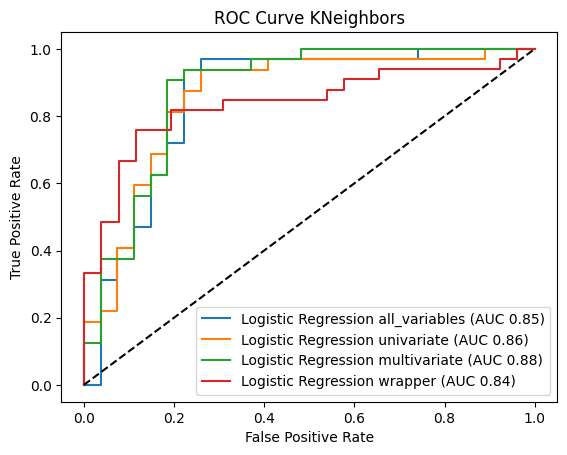

In [6]:
### Logistic Regression
from sklearn.metrics import confusion_matrix






from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score




model=LogisticRegression()

aucs_=[]
tprs_=[]
fprs_=[]


for a_set in X_lib.keys():

  


    X_vars=X_lib[a_set]

    variables=a_set

    print('variables method: '+variables)

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)
 

    if variables=='wrapper':
        
    
        # Apply Forward Selection with 9 variables
        selector = SequentialFeatureSelector(estimator=model, n_features_to_select=7, direction='forward')

        selector.fit(X_train, y_train)

        # Get the boolean mask of the selected features
        selected_mask = selector.get_support()

        # Get the indices of the selected features
        selected_indices = [i for i, x in enumerate(selected_mask) if x]


        X_vars=X_vars[:,selected_indices]

        # print(np.shape(X_vars))
    
   
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)


     ## use gridsearch 
     
    grid ={"penalty":['l1','l2'],
           'C':[.5,.75,1,1.25,1.5,2],
           'solver':['liblinear']
           }
    model= LogisticRegression()


   
    ## Implement Grid Search
    from sklearn.model_selection import GridSearchCV


    gs_cv=GridSearchCV(model,grid,cv=5,n_jobs=-1) #GridSearchCV
    print('Grid Search')
    gs_cv.fit(X_train,y_train)
    # print("tuned hyperparameter K:",gs_cv.best_params_)


    ## use KFold CV as well using the GridSearch Parameters
    from sklearn.model_selection import KFold
    scores=[]
    precisions=[]
    recalls=[]
    f1s=[]

    tps=[]
    tns=[]
    fps=[]
    fns=[]

    aucs=[]
    tprs=[]
    fprs=[]

    n_tps=0
    n_tns=0

    
    n_fps=0
    

    kFold=KFold(n_splits=5,shuffle=False)

    # use best gridsearch parameter
   
    counter=1
    print('Cross Validation')
    for train_index,test_index in kFold.split(X_vars):
        # print('Fold #'+str(counter))
        
        model=LogisticRegression(penalty=gs_cv.best_params_['penalty'],C=gs_cv.best_params_['C'],
                                  solver=gs_cv.best_params_['solver'] )

        X_train, X_test, y_train, y_test = X_vars[train_index], X_vars[test_index], y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        scores.append(model.score(X_test, y_test))

        preds=model.predict(X_test)

        C=confusion_matrix(y_test, preds)

        print(C)


        tp=C[0,0]
        tn=C[1,1]

        fp=C[1,0]
        fn=C[0,1]

        tps.append(tp)
        tns.append(tn)
        
        fps.append(fp)
        fns.append(fn)

        precision=tp/(tp+fp)

        precisions.append(precision)

        recall=tp/(tp+fn)

        recalls.append(recall)



        f1=2*tp/((2*tp)+fp+fn)

        f1s.append(f1)

        y_prob=model.predict_proba(X_test)

        y_prob=y_prob[:,-1]

        auc=roc_auc_score(y_test,y_prob).mean()

        aucs.append(auc) 

        
        fpr, tpr, _ = roc_curve(y_test, y_prob)

        fprs.append(fpr)
        tprs.append(tpr)

    

        counter+=1



    med_auc_idx=aucs.index(stat.median(aucs))

    fprs_.append(fprs[med_auc_idx])
    tprs_.append(tprs[med_auc_idx])
    aucs_.append(aucs[med_auc_idx])







    # print(precisions)
    # print(recalls)
    # print(f1s)
    # print(tps)

    kfold_mean_precision=np.mean(precisions)
    kfold_mean_recall=np.mean(recalls)
    kfold_mean_f1=np.mean(f1s)

    kfold_min_precision=np.min(precisions)
    kfold_min_recall=np.max(recalls)
    kfold_min_f1=np.min(f1s)

    kfold_max_precision=np.max(precisions)
    kfold_max_recall=np.max(recalls)
    kfold_max_f1=np.max(f1s)

    
    kfold_mean_tps=np.mean(tps)
    kfold_mean_tns=np.mean(tns)
    kfold_mean_fps=np.mean(fps)
    kfold_mean_fns=np.mean(fns)


    kfold_mean_accuracy=np.mean(scores)
    kfold_min_accuracy=np.min(scores)
    kfold_max_accuracy=np.max(scores)

    kfold_min_auc=np.min(aucs)
    kfold_mean_auc=np.mean(aucs)
    kfold_max_auc=np.max(aucs)



    temp_results=pd.DataFrame({'algorithm':['Logistic Regression'],
                               'variable_method':[variables],
                               'hyper_parameters':[gs_cv.best_params_],
                               'cv_min_accuracy':[kfold_min_accuracy],
                               'cv_max_accuracy':[kfold_min_accuracy],
                               'cv_mean_accuracy':[kfold_min_accuracy],
                               'cv_min_recall':[kfold_min_recall],
                               'cv_max_recall':[kfold_max_recall],
                               'cv_mean_recall':[kfold_mean_recall],                   
                               'cv_min_precision':[kfold_min_precision],
                               'cv_max_precision':[kfold_max_precision],
                               'cv_mean_precision':[kfold_mean_precision],
                               'cv_min_f1':[kfold_min_f1],
                               'cv_max_f1':[kfold_max_f1],
                               'cv_mean_f1':[kfold_mean_f1],
                               'cv_mean_tps':[kfold_mean_tps],
                               'cv_mean_tns':[kfold_mean_tns],
                               'cv_mean_fps':[kfold_mean_fps],
                               'cv_mean_fns':[kfold_mean_fns],
                               'cv_mean_auc':[kfold_mean_auc],
                               'cv_min_auc':[kfold_min_auc],
                               'cv_max_auc':[kfold_max_auc]
                               })
    model_results=pd.concat([model_results,temp_results])


## Plot AUC best with each method
plt.figure()



methods=['all_variables','univariate','multivariate','wrapper']

for idx in range(0,len(X_lib.keys())):
    cur_method=methods[idx]
    plt.plot(fprs_[idx], tprs_[idx], label=f"Logistic Regression "+cur_method+f" (AUC {aucs_[idx]:.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve KNeighbors")
plt.legend(loc="best")
# plt.show()

plt.savefig('AUC_comparison_LogisticRegression.png')


In [18]:
print(roc_auc_score(y_test,y_prob))

0.9302884615384616


variables method: all_features
Grid Search
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Cross Validation
variables method: univariate_filter
Grid Search
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Cross Validation
variables method: multivariate
Grid Search
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Cross Validation
variables method: wrapper
Grid Search
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Cross Validation


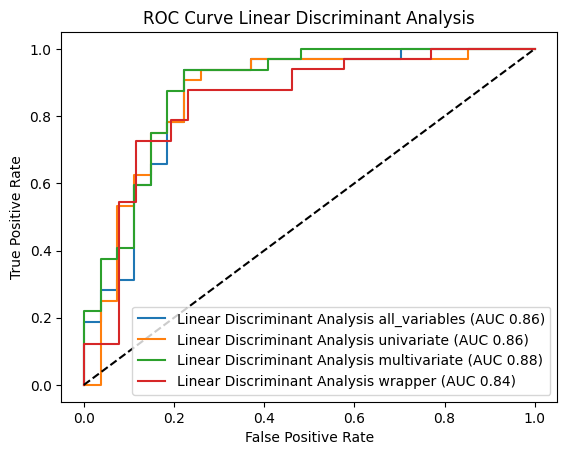

In [7]:
### Linear Discriminant Analysis
from sklearn.metrics import confusion_matrix







from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score




model=LinearDiscriminantAnalysis()


aucs_=[]
tprs_=[]
fprs_=[]



for a_set in X_lib.keys():

    X_vars=X_lib[a_set]

    variables=a_set

    print('variables method: '+variables)


    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)


    if variables=='wrapper':
        
    
        # Apply Forward Selection with 8 variables
        selector = SequentialFeatureSelector(estimator=model, n_features_to_select=7, direction='forward')

        selector.fit(X_train, y_train)

        # Get the boolean mask of the selected features
        selected_mask = selector.get_support()

        # Get the indices of the selected features
        selected_indices = [i for i, x in enumerate(selected_mask) if x]


        X_vars=X_vars[:,selected_indices]

        # print(np.shape(X_vars))
    
   
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)


     ## use gridsearch 
    
    model= LinearDiscriminantAnalysis()



    grid ={"shrinkage":['auto',.01,.1,.3,.5],
           'solver':['lsqr','eigen']
           }
   
    ## Implement Grid Search
    from sklearn.model_selection import GridSearchCV


    gs_cv=GridSearchCV(model,grid,cv=5,n_jobs=-1,verbose=2) #GridSearchCV
    print('Grid Search')
    gs_cv.fit(X_train,y_train)
    # print("tuned hyperparameter K:",gs_cv.best_params_)


    ## use KFold CV as well using the GridSearch Parameters
    from sklearn.model_selection import KFold
    scores=[]
    precisions=[]
    recalls=[]
    f1s=[]

    tps=[]
    tns=[]
    fps=[]
    fns=[]
    aucs=[]

    fprs=[]
    tprs=[]
    

    kFold=KFold(n_splits=5,shuffle=False)

    # use best gridsearch parameter
   
    counter=1
    print('Cross Validation')
    for train_index,test_index in kFold.split(X_vars):
        # print('Fold #'+str(counter))
        
        model=LinearDiscriminantAnalysis(shrinkage=gs_cv.best_params_['shrinkage'],
                                  solver=gs_cv.best_params_['solver'] )
        X_train, X_test, y_train, y_test = X_vars[train_index], X_vars[test_index], y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        scores.append(model.score(X_test, y_test))

        preds=model.predict(X_test)

        C=confusion_matrix(y_test, preds)

        # print(C)


        tp=C[0,0]
        tn=C[1,1]

        fp=C[1,0]
        fn=C[0,1]

        tps.append(tp)
        tns.append(tn)
        
        fps.append(fp)
        fns.append(fn)

        precision=tp/(tp+fp)

        precisions.append(precision)

        recall=tp/(tp+fn)

        recalls.append(recall)



        f1=2*tp/((2*tp)+fp+fn)

        f1s.append(f1)

        y_prob=model.predict_proba(X_test)

        y_prob=y_prob[:,-1]

        auc=roc_auc_score(y_test,y_prob).mean()

        aucs.append(auc) 

        fpr, tpr, _ = roc_curve(y_test, y_prob)

        fprs.append(fpr)
        tprs.append(tpr)

        

        counter+=1


    med_auc_idx=aucs.index(stat.median(aucs))

    fprs_.append(fprs[med_auc_idx])
    tprs_.append(tprs[med_auc_idx])
    aucs_.append(aucs[med_auc_idx])

    # print(precisions)
    # print(recalls)
    # print(f1s)
    # print(tps)

    kfold_mean_precision=np.mean(precisions)
    kfold_mean_recall=np.mean(recalls)
    kfold_mean_f1=np.mean(f1s)

    kfold_min_precision=np.min(precisions)
    kfold_min_recall=np.max(recalls)
    kfold_min_f1=np.min(f1s)

    kfold_max_precision=np.max(precisions)
    kfold_max_recall=np.max(recalls)
    kfold_max_f1=np.max(f1s)

    
    kfold_mean_tps=np.mean(tps)
    kfold_mean_tns=np.mean(tns)
    kfold_mean_fps=np.mean(fps)
    kfold_mean_fns=np.mean(fns)


    kfold_mean_accuracy=np.mean(scores)
    kfold_min_accuracy=np.min(scores)
    kfold_max_accuracy=np.max(scores)

    kfold_min_auc=np.min(aucs)
    kfold_mean_auc=np.mean(aucs)
    kfold_max_auc=np.max(aucs)



    temp_results=pd.DataFrame({'algorithm':['SVC'],
                                'variable_method':[variables],
                                'hyper_parameters':[gs_cv.best_params_],
                                'cv_min_accuracy':[kfold_min_accuracy],
                                'cv_max_accuracy':[kfold_min_accuracy],
                                'cv_mean_accuracy':[kfold_min_accuracy],
                                'cv_min_recall':[kfold_min_recall],
                                'cv_max_recall':[kfold_max_recall],
                                'cv_mean_recall':[kfold_mean_recall],                   
                                'cv_min_precision':[kfold_min_precision],
                                'cv_max_precision':[kfold_max_precision],
                                'cv_mean_precision':[kfold_mean_precision],
                                'cv_min_f1':[kfold_min_f1],
                                'cv_max_f1':[kfold_max_f1],
                                'cv_mean_f1':[kfold_mean_f1],
                                'cv_mean_tps':[kfold_mean_tps],
                                'cv_mean_tns':[kfold_mean_tns],
                                'cv_mean_fps':[kfold_mean_fps],
                                'cv_mean_fns':[kfold_mean_fns],
                                'cv_mean_auc':[kfold_mean_auc],
                                'cv_min_auc':[kfold_min_auc],
                                'cv_max_auc':[kfold_max_auc]
                                })
    model_results=pd.concat([model_results,temp_results])



## Plot AUC best with each method
plt.figure()



methods=['all_variables','univariate','multivariate','wrapper']

for idx in range(0,len(X_lib.keys())):
    cur_method=methods[idx]
    plt.plot(fprs_[idx], tprs_[idx], label=f"Linear Discriminant Analysis "+cur_method+f" (AUC {aucs_[idx]:.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Linear Discriminant Analysis")
plt.legend(loc="best")
# plt.show()


plt.savefig('AUC_comparison_LDA.png')

model_results.to_csv('model_results_probabilistic.csv',index=False)

variables method: all_features
Grid Search
Cross Validation
[[23  9]
 [ 7 20]]
[[21  6]
 [ 4 28]]
[[21  5]
 [ 3 30]]
[[20 11]
 [ 6 21]]
[[23  3]
 [ 5 27]]
variables method: univariate_filter
Grid Search
Cross Validation
[[25  7]
 [ 7 20]]
[[21  6]
 [ 4 28]]
[[22  4]
 [ 6 27]]
[[19 12]
 [ 4 23]]
[[23  3]
 [ 3 29]]
variables method: multivariate
Grid Search
Cross Validation
[[24  8]
 [ 6 21]]
[[21  6]
 [ 3 29]]
[[22  4]
 [ 7 26]]
[[21 10]
 [ 6 21]]
[[24  2]
 [ 3 29]]
variables method: wrapper
Grid Search
Cross Validation
[[23  9]
 [ 6 21]]
[[21  6]
 [ 4 28]]
[[21  5]
 [ 9 24]]
[[23  8]
 [ 5 22]]
[[24  2]
 [ 4 28]]


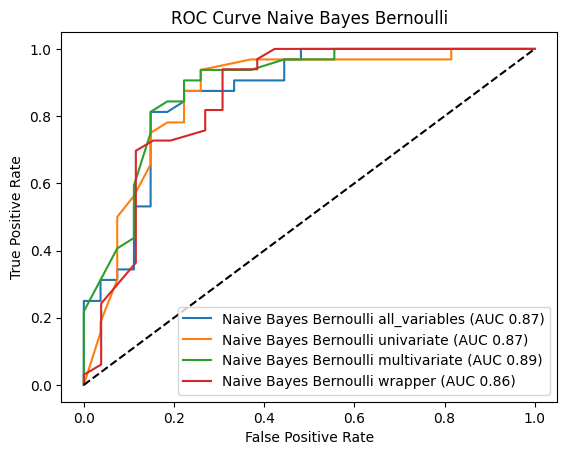

In [8]:
### Naive Bayes
from sklearn.metrics import confusion_matrix







from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import KBinsDiscretizer


model=BernoulliNB()

aucs_=[]
tprs_=[]
fprs_=[]


for a_set in X_lib.keys():

    Xvars=X_lib[a_set]

    variables=a_set

    kbin_discretizer = KBinsDiscretizer(n_bins=5,encode='ordinal',strategy='uniform')

    cols_to_bin=np.empty((293,1))
    X_vars=np.empty((293,1))
    for a_col in range(0,Xvars.shape[1]):
        
        if len(np.unique(Xvars[:,a_col]).tolist())>2:  
       
            cols_to_bin=np.concatenate((cols_to_bin,Xvars[:,a_col].reshape(-1,1)),axis=1)
        else:
            X_vars=np.concatenate((X_vars,Xvars[:,a_col].reshape(-1,1)),axis=1)

    binned_cols=kbin_discretizer.fit_transform(cols_to_bin[:,1:])

    X_vars=np.concatenate((X_vars,binned_cols),axis=1)


    print('variables method: '+variables)
    X_vars=X_vars[:,1:]

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)
 

    if variables=='wrapper':
        
    
        # Apply Forward Selection with 9 variables
        selector = SequentialFeatureSelector(estimator=model, n_features_to_select=7, direction='forward')

        selector.fit(X_train, y_train)

        # Get the boolean mask of the selected features
        selected_mask = selector.get_support()

        # Get the indices of the selected features
        selected_indices = [i for i, x in enumerate(selected_mask) if x]


        X_vars=X_vars[:,selected_indices]

        # print(np.shape(X_vars))
    
   
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)


     ## use gridsearch 
    
    grid={'alpha':[2,.4,.6,.8,
                     1,1.2,1.4,1.6,1.8,2]
           }
    model= BernoulliNB()


   
    ## Implement Grid Search
    from sklearn.model_selection import GridSearchCV


    gs_cv=GridSearchCV(model,grid,cv=5,n_jobs=-1) #GridSearchCV
    print('Grid Search')
    gs_cv.fit(X_train,y_train)
    # print("tuned hyperparameter K:",gs_cv.best_params_)


    ## use KFold CV as well using the GridSearch Parameters
    from sklearn.model_selection import KFold
    scores=[]
    precisions=[]
    recalls=[]
    f1s=[]

    tps=[]
    tns=[]
    fps=[]
    fns=[]

    aucs=[]
    tprs=[]
    fprs=[]

    n_tps=0
    n_tns=0

    
    n_fps=0
    

    kFold=KFold(n_splits=5,shuffle=False)

    # use best gridsearch parameter
   
    counter=1
    print('Cross Validation')
    for train_index,test_index in kFold.split(X_vars):
        # print('Fold #'+str(counter))
        
        model=BernoulliNB(alpha=gs_cv.best_params_['alpha']
                                  )

        X_train, X_test, y_train, y_test = X_vars[train_index], X_vars[test_index], y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        scores.append(model.score(X_test, y_test))

        preds=model.predict(X_test)

        C=confusion_matrix(y_test, preds)

        print(C)


        tp=C[0,0]
        tn=C[1,1]

        fp=C[1,0]
        fn=C[0,1]

        tps.append(tp)
        tns.append(tn)
        
        fps.append(fp)
        fns.append(fn)

        precision=tp/(tp+fp)

        precisions.append(precision)

        recall=tp/(tp+fn)

        recalls.append(recall)



        f1=2*tp/((2*tp)+fp+fn)

        f1s.append(f1)

        y_prob=model.predict_proba(X_test)

        y_prob=y_prob[:,-1]

        auc=roc_auc_score(y_test,y_prob).mean()

        aucs.append(auc) 

        
        fpr, tpr, _ = roc_curve(y_test, y_prob)

        fprs.append(fpr)
        tprs.append(tpr)

    

        counter+=1



    med_auc_idx=aucs.index(stat.median(aucs))

    fprs_.append(fprs[med_auc_idx])
    tprs_.append(tprs[med_auc_idx])
    aucs_.append(aucs[med_auc_idx])







    # print(precisions)
    # print(recalls)
    # print(f1s)
    # print(tps)

    kfold_mean_precision=np.mean(precisions)
    kfold_mean_recall=np.mean(recalls)
    kfold_mean_f1=np.mean(f1s)

    kfold_min_precision=np.min(precisions)
    kfold_min_recall=np.max(recalls)
    kfold_min_f1=np.min(f1s)

    kfold_max_precision=np.max(precisions)
    kfold_max_recall=np.max(recalls)
    kfold_max_f1=np.max(f1s)

    
    kfold_mean_tps=np.mean(tps)
    kfold_mean_tns=np.mean(tns)
    kfold_mean_fps=np.mean(fps)
    kfold_mean_fns=np.mean(fns)


    kfold_mean_accuracy=np.mean(scores)
    kfold_min_accuracy=np.min(scores)
    kfold_max_accuracy=np.max(scores)

    kfold_min_auc=np.min(aucs)
    kfold_mean_auc=np.mean(aucs)
    kfold_max_auc=np.max(aucs)



    temp_results=pd.DataFrame({'algorithm':['Linear Discriminant'],
                               'variable_method':[variables],
                               'hyper_parameters':[gs_cv.best_params_],
                               'cv_min_accuracy':[kfold_min_accuracy],
                               'cv_max_accuracy':[kfold_min_accuracy],
                               'cv_mean_accuracy':[kfold_min_accuracy],
                               'cv_min_recall':[kfold_min_recall],
                               'cv_max_recall':[kfold_max_recall],
                               'cv_mean_recall':[kfold_mean_recall],                   
                               'cv_min_precision':[kfold_min_precision],
                               'cv_max_precision':[kfold_max_precision],
                               'cv_mean_precision':[kfold_mean_precision],
                               'cv_min_f1':[kfold_min_f1],
                               'cv_max_f1':[kfold_max_f1],
                               'cv_mean_f1':[kfold_mean_f1],
                               'cv_mean_tps':[kfold_mean_tps],
                               'cv_mean_tns':[kfold_mean_tns],
                               'cv_mean_fps':[kfold_mean_fps],
                               'cv_mean_fns':[kfold_mean_fns],
                               'cv_mean_auc':[kfold_mean_auc],
                               'cv_min_auc':[kfold_min_auc],
                               'cv_max_auc':[kfold_max_auc]
                               })
    model_results=pd.concat([model_results,temp_results])


## Plot AUC best with each method
plt.figure()



methods=['all_variables','univariate','multivariate','wrapper']

for idx in range(0,len(X_lib.keys())):
    cur_method=methods[idx]
    plt.plot(fprs_[idx], tprs_[idx], label=f"Naive Bayes Bernoulli "+cur_method+f" (AUC {aucs_[idx]:.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Naive Bayes Bernoulli")
plt.legend(loc="best")
# plt.show()

plt.savefig('AUC_comparison_NBB.png')

model_results.to_csv('model_results_probabilistic.csv',index=False)


variables method: all_features
Grid Search
Cross Validation
[[24  8]
 [ 6 21]]
[[21  6]
 [ 5 27]]
[[21  5]
 [ 6 27]]
[[19 12]
 [ 5 22]]
[[23  3]
 [ 3 29]]
variables method: univariate_filter
Grid Search
Cross Validation
[[24  8]
 [ 6 21]]
[[21  6]
 [ 4 28]]
[[22  4]
 [ 9 24]]
[[23  8]
 [ 4 23]]
[[25  1]
 [ 3 29]]
variables method: multivariate
Grid Search
Cross Validation
[[24  8]
 [ 6 21]]
[[21  6]
 [ 2 30]]
[[22  4]
 [ 9 24]]
[[21 10]
 [ 7 20]]
[[25  1]
 [ 3 29]]
variables method: wrapper
Grid Search
Cross Validation
[[24  8]
 [ 6 21]]
[[21  6]
 [ 4 28]]
[[22  4]
 [ 9 24]]
[[24  7]
 [ 6 21]]
[[23  3]
 [ 4 28]]


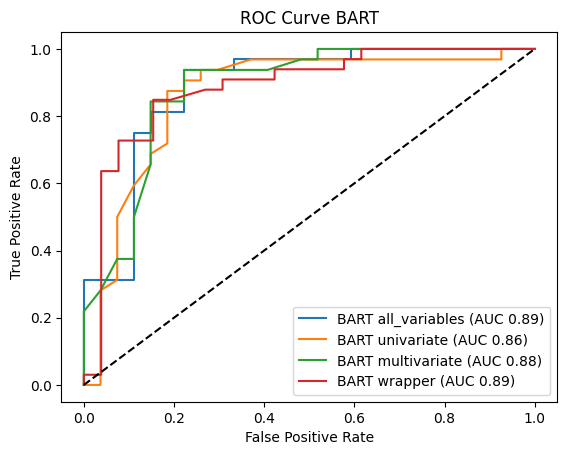

In [11]:
### Bayesian additive regression trees
from sklearn.metrics import confusion_matrix





from bartpy.sklearnmodel import SklearnModel

from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import KBinsDiscretizer


model=SklearnModel()

aucs_=[]
tprs_=[]
fprs_=[]


for a_set in X_lib.keys():

    Xvars=X_lib[a_set]

    variables=a_set

    kbin_discretizer = KBinsDiscretizer(n_bins=5,encode='ordinal',strategy='uniform')

    cols_to_bin=np.empty((293,1))
    X_vars=np.empty((293,1))
    for a_col in range(0,Xvars.shape[1]):
        
        if len(np.unique(Xvars[:,a_col]).tolist())>2:  
       
            cols_to_bin=np.concatenate((cols_to_bin,Xvars[:,a_col].reshape(-1,1)),axis=1)
        else:
            X_vars=np.concatenate((X_vars,Xvars[:,a_col].reshape(-1,1)),axis=1)

    binned_cols=kbin_discretizer.fit_transform(cols_to_bin[:,1:])

    X_vars=np.concatenate((X_vars,binned_cols),axis=1)


    print('variables method: '+variables)
    X_vars=X_vars[:,1:]

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)
 

    if variables=='wrapper':
        
    
        # Apply Forward Selection with 9 variables
        selector = SequentialFeatureSelector(estimator=model, n_features_to_select=7, direction='forward')

        selector.fit(X_train, y_train)

        # Get the boolean mask of the selected features
        selected_mask = selector.get_support()

        # Get the indices of the selected features
        selected_indices = [i for i, x in enumerate(selected_mask) if x]


        X_vars=X_vars[:,selected_indices]

        # print(np.shape(X_vars))
    
   
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)


     ## use gridsearch 
    
    grid={'n_trees':[50,75,100,125,150,175,200],
          'n_samples':np.arange(1,15)
           }

    model= SklearnModel()
  
    ## Implement Grid Search
    from sklearn.model_selection import GridSearchCV


    gs_cv=GridSearchCV(model,grid,cv=5,n_jobs=-1) #GridSearchCV
    print('Grid Search')
    gs_cv.fit(X_train,y_train)
    # print("tuned hyperparameter K:",gs_cv.best_params_)


    ## use KFold CV as well using the GridSearch Parameters
    from sklearn.model_selection import KFold
    scores=[]
    precisions=[]
    recalls=[]
    f1s=[]

    tps=[]
    tns=[]
    fps=[]
    fns=[]

    aucs=[]
    tprs=[]
    fprs=[]

    n_tps=0
    n_tns=0

    
    n_fps=0
    

    kFold=KFold(n_splits=5,shuffle=False)

    # use best gridsearch parameter
   
    counter=1
    print('Cross Validation')
    for train_index,test_index in kFold.split(X_vars):
        # print('Fold #'+str(counter))
        
        model=SklearnModel(n_trees=gs_cv.best_params_['n_trees'],
                           n_samples=gs_cv.best_params_['n_samples']
        )

        X_train, X_test, y_train, y_test = X_vars[train_index], X_vars[test_index], y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        

        scores.append(model.score(X_test, y_test))

        preds_=model.predict(X_test)

        preds=[]
        for a_pred in preds_:
            if a_pred>=.5:
                preds.append(1)
            else:
                preds.append(0)



        C=confusion_matrix(y_test, preds)

        print(C)


        tp=C[0,0]
        tn=C[1,1]

        fp=C[1,0]
        fn=C[0,1]

        tps.append(tp)
        tns.append(tn)
        
        fps.append(fp)
        fns.append(fn)

        precision=tp/(tp+fp)

        precisions.append(precision)

        recall=tp/(tp+fn)

        recalls.append(recall)



        f1=2*tp/((2*tp)+fp+fn)

        f1s.append(f1)

        y_prob=preds_


        auc=roc_auc_score(y_test,y_prob).mean()

        aucs.append(auc) 

        
        fpr, tpr, _ = roc_curve(y_test, y_prob)

        fprs.append(fpr)
        tprs.append(tpr)

    

        counter+=1



    med_auc_idx=aucs.index(stat.median(aucs))

    fprs_.append(fprs[med_auc_idx])
    tprs_.append(tprs[med_auc_idx])
    aucs_.append(aucs[med_auc_idx])







    # print(precisions)
    # print(recalls)
    # print(f1s)
    # print(tps)

    kfold_mean_precision=np.mean(precisions)
    kfold_mean_recall=np.mean(recalls)
    kfold_mean_f1=np.mean(f1s)

    kfold_min_precision=np.min(precisions)
    kfold_min_recall=np.max(recalls)
    kfold_min_f1=np.min(f1s)

    kfold_max_precision=np.max(precisions)
    kfold_max_recall=np.max(recalls)
    kfold_max_f1=np.max(f1s)

    
    kfold_mean_tps=np.mean(tps)
    kfold_mean_tns=np.mean(tns)
    kfold_mean_fps=np.mean(fps)
    kfold_mean_fns=np.mean(fns)


    kfold_mean_accuracy=np.mean(scores)
    kfold_min_accuracy=np.min(scores)
    kfold_max_accuracy=np.max(scores)

    kfold_min_auc=np.min(aucs)
    kfold_mean_auc=np.mean(aucs)
    kfold_max_auc=np.max(aucs)



    temp_results=pd.DataFrame({'algorithm':['BART'],
                               'variable_method':[variables],
                               'hyper_parameters':[gs_cv.best_params_],
                               'cv_min_accuracy':[kfold_min_accuracy],
                               'cv_max_accuracy':[kfold_min_accuracy],
                               'cv_mean_accuracy':[kfold_min_accuracy],
                               'cv_min_recall':[kfold_min_recall],
                               'cv_max_recall':[kfold_max_recall],
                               'cv_mean_recall':[kfold_mean_recall],                   
                               'cv_min_precision':[kfold_min_precision],
                               'cv_max_precision':[kfold_max_precision],
                               'cv_mean_precision':[kfold_mean_precision],
                               'cv_min_f1':[kfold_min_f1],
                               'cv_max_f1':[kfold_max_f1],
                               'cv_mean_f1':[kfold_mean_f1],
                               'cv_mean_tps':[kfold_mean_tps],
                               'cv_mean_tns':[kfold_mean_tns],
                               'cv_mean_fps':[kfold_mean_fps],
                               'cv_mean_fns':[kfold_mean_fns],
                               'cv_mean_auc':[kfold_mean_auc],
                               'cv_min_auc':[kfold_min_auc],
                               'cv_max_auc':[kfold_max_auc]
                               })
    model_results=pd.concat([model_results,temp_results])


## Plot AUC best with each method
plt.figure()



methods=['all_variables','univariate','multivariate','wrapper']

for idx in range(0,len(X_lib.keys())):
    cur_method=methods[idx]
    plt.plot(fprs_[idx], tprs_[idx], label=f"BART "+cur_method+f" (AUC {aucs_[idx]:.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve BART")
plt.legend(loc="best")
# plt.show()

plt.savefig('AUC_comparison_BART.png')

model_results.to_csv('model_results_probabilistic.csv',index=False)


variables method: all_features
Grid Search


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 2700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\bas

Cross Validation
[[23  9]
 [ 6 21]]
[[22  5]
 [ 3 29]]
[[22  4]
 [ 7 26]]
[[22  9]
 [ 5 22]]
[[24  2]
 [ 3 29]]
variables method: univariate_filter
Grid Search


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 2700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\bas

Cross Validation
[[24  8]
 [ 6 21]]
[[21  6]
 [ 4 28]]
[[22  4]
 [ 9 24]]
[[24  7]
 [14 13]]
[[19  7]
 [ 3 29]]
variables method: multivariate
Grid Search


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 2700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\bas

Cross Validation
[[21 11]
 [ 3 24]]
[[22  5]
 [ 3 29]]
[[22  4]
 [ 4 29]]
[[19 12]
 [ 5 22]]
[[22  4]
 [ 3 29]]
variables method: wrapper
Grid Search


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 2700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\bas

Cross Validation
[[24  8]
 [ 6 21]]
[[18  9]
 [ 3 29]]
[[22  4]
 [ 9 24]]
[[20 11]
 [10 17]]
[[20  6]
 [ 3 29]]


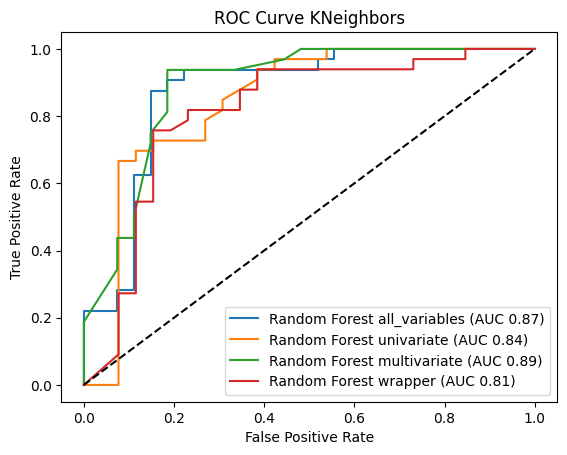

In [ ]:
### Random Forest
from sklearn.metrics import confusion_matrix






from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score




model=RandomForestClassifier()

aucs_=[]
tprs_=[]
fprs_=[]


for a_set in X_lib.keys():

  


    X_vars=X_lib[a_set]

    variables=a_set

    print('variables method: '+variables)

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)
 

    if variables=='wrapper':
        
    
        # Apply Forward Selection with 9 variables
        selector = SequentialFeatureSelector(estimator=model, n_features_to_select=7, direction='forward')

        selector.fit(X_train, y_train)

        # Get the boolean mask of the selected features
        selected_mask = selector.get_support()

        # Get the indices of the selected features
        selected_indices = [i for i, x in enumerate(selected_mask) if x]


        X_vars=X_vars[:,selected_indices]

        # print(np.shape(X_vars))
    
   
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)


     ## use gridsearch 
     
    grid ={"n_estimators":[100,150,200],
            'max_features': [1,3,6,9,12,15],
            'max_depth': [1,3,6,9,12,15],
            'min_samples_split':[1,3,5,7,10]
           }
    model= RandomForestClassifier()


   
    ## Implement Grid Search
    from sklearn.model_selection import GridSearchCV


    gs_cv=GridSearchCV(model,grid,cv=5,n_jobs=-1) #GridSearchCV
    print('Grid Search')
    gs_cv.fit(X_train,y_train)
    # print("tuned hyperparameter K:",gs_cv.best_params_)


    ## use KFold CV as well using the GridSearch Parameters
    from sklearn.model_selection import KFold
    scores=[]
    precisions=[]
    recalls=[]
    f1s=[]

    tps=[]
    tns=[]
    fps=[]
    fns=[]

    aucs=[]
    tprs=[]
    fprs=[]

    n_tps=0
    n_tns=0

    
    n_fps=0
    

    kFold=KFold(n_splits=5,shuffle=False)

    # use best gridsearch parameter
   
    counter=1
    print('Cross Validation')
    for train_index,test_index in kFold.split(X_vars):
        # print('Fold #'+str(counter))
        
        model=RandomForestClassifier(n_estimators=gs_cv.best_params_['n_estimators'],
                                    max_features=gs_cv.best_params_['max_features'],
                                     max_depth=gs_cv.best_params_['max_depth'],
                                     min_samples_split=gs_cv.best_params_['min_samples_split'])

        X_train, X_test, y_train, y_test = X_vars[train_index], X_vars[test_index], y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        scores.append(model.score(X_test, y_test))

        preds=model.predict(X_test)

        C=confusion_matrix(y_test, preds)

        print(C)


        tp=C[0,0]
        tn=C[1,1]

        fp=C[1,0]
        fn=C[0,1]

        tps.append(tp)
        tns.append(tn)
        
        fps.append(fp)
        fns.append(fn)

        precision=tp/(tp+fp)

        precisions.append(precision)

        recall=tp/(tp+fn)

        recalls.append(recall)



        f1=2*tp/((2*tp)+fp+fn)

        f1s.append(f1)

        y_prob=model.predict_proba(X_test)

        y_prob=y_prob[:,-1]

        auc=roc_auc_score(y_test,y_prob).mean()

        aucs.append(auc) 

        
        fpr, tpr, _ = roc_curve(y_test, y_prob)

        fprs.append(fpr)
        tprs.append(tpr)

    

        counter+=1



    med_auc_idx=aucs.index(stat.median(aucs))

    fprs_.append(fprs[med_auc_idx])
    tprs_.append(tprs[med_auc_idx])
    aucs_.append(aucs[med_auc_idx])







    # print(precisions)
    # print(recalls)
    # print(f1s)
    # print(tps)

    kfold_mean_precision=np.mean(precisions)
    kfold_mean_recall=np.mean(recalls)
    kfold_mean_f1=np.mean(f1s)

    kfold_min_precision=np.min(precisions)
    kfold_min_recall=np.max(recalls)
    kfold_min_f1=np.min(f1s)

    kfold_max_precision=np.max(precisions)
    kfold_max_recall=np.max(recalls)
    kfold_max_f1=np.max(f1s)

    
    kfold_mean_tps=np.mean(tps)
    kfold_mean_tns=np.mean(tns)
    kfold_mean_fps=np.mean(fps)
    kfold_mean_fns=np.mean(fns)


    kfold_mean_accuracy=np.mean(scores)
    kfold_min_accuracy=np.min(scores)
    kfold_max_accuracy=np.max(scores)

    kfold_min_auc=np.min(aucs)
    kfold_mean_auc=np.mean(aucs)
    kfold_max_auc=np.max(aucs)



    temp_results=pd.DataFrame({'algorithm':['Random Forest'],
                               'variable_method':[variables],
                               'hyper_parameters':[gs_cv.best_params_],
                               'cv_min_accuracy':[kfold_min_accuracy],
                               'cv_max_accuracy':[kfold_min_accuracy],
                               'cv_mean_accuracy':[kfold_min_accuracy],
                               'cv_min_recall':[kfold_min_recall],
                               'cv_max_recall':[kfold_max_recall],
                               'cv_mean_recall':[kfold_mean_recall],                   
                               'cv_min_precision':[kfold_min_precision],
                               'cv_max_precision':[kfold_max_precision],
                               'cv_mean_precision':[kfold_mean_precision],
                               'cv_min_f1':[kfold_min_f1],
                               'cv_max_f1':[kfold_max_f1],
                               'cv_mean_f1':[kfold_mean_f1],
                               'cv_mean_tps':[kfold_mean_tps],
                               'cv_mean_tns':[kfold_mean_tns],
                               'cv_mean_fps':[kfold_mean_fps],
                               'cv_mean_fns':[kfold_mean_fns],
                               'cv_mean_auc':[kfold_mean_auc],
                               'cv_min_auc':[kfold_min_auc],
                               'cv_max_auc':[kfold_max_auc]
                               })
    model_results=pd.concat([model_results,temp_results])


## Plot AUC best with each method
plt.figure()



methods=['all_variables','univariate','multivariate','wrapper']

for idx in range(0,len(X_lib.keys())):
    cur_method=methods[idx]
    plt.plot(fprs_[idx], tprs_[idx], label=f"Random Forest "+cur_method+f" (AUC {aucs_[idx]:.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Random Forest")
plt.legend(loc="best")
# plt.show()

plt.savefig('AUC_comparison_RandomForest.png')

model_results.to_csv('model_results_probabilistic.csv',index=False)

variables method: all_features
Grid Search
Cross Validation
[[22 10]
 [ 6 21]]
[[21  6]
 [ 4 28]]
[[22  4]
 [ 9 24]]
[[16 15]
 [ 3 24]]
[[16 10]
 [ 2 30]]
variables method: univariate_filter
Grid Search
Cross Validation
[[21 11]
 [ 1 26]]
[[21  6]
 [ 4 28]]
[[22  4]
 [ 9 24]]
[[16 15]
 [ 3 24]]
[[16 10]
 [ 2 30]]
variables method: multivariate
Grid Search
Cross Validation
[[24  8]
 [ 7 20]]
[[23  4]
 [ 5 27]]
[[22  4]
 [ 8 25]]
[[19 12]
 [ 4 23]]
[[23  3]
 [ 3 29]]
variables method: wrapper
Grid Search
Cross Validation
[[24  8]
 [ 6 21]]
[[21  6]
 [ 4 28]]
[[22  4]
 [ 9 24]]
[[23  8]
 [ 5 22]]
[[24  2]
 [ 3 29]]


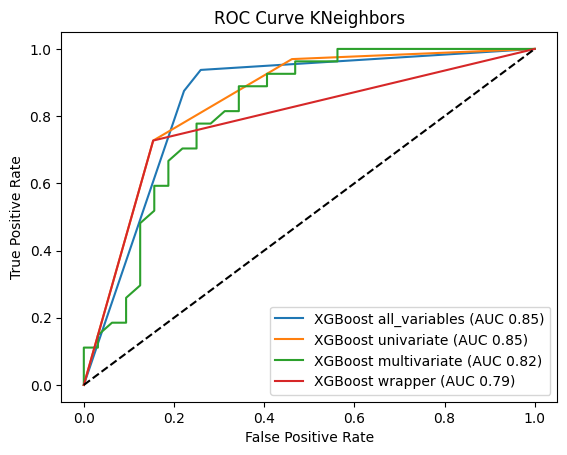

In [ ]:
### XGBoost Classification
from sklearn.metrics import confusion_matrix






from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score




model=XGBClassifier()

aucs_=[]
tprs_=[]
fprs_=[]


for a_set in X_lib.keys():

  


    X_vars=X_lib[a_set]

    variables=a_set

    print('variables method: '+variables)

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)
 

    if variables=='wrapper':
        
    
        # Apply Forward Selection with 9 variables
        selector = SequentialFeatureSelector(estimator=model, n_features_to_select=7, direction='forward')

        selector.fit(X_train, y_train)

        # Get the boolean mask of the selected features
        selected_mask = selector.get_support()

        # Get the indices of the selected features
        selected_indices = [i for i, x in enumerate(selected_mask) if x]


        X_vars=X_vars[:,selected_indices]

        # print(np.shape(X_vars))
    
   
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)


     ## use gridsearch 
     
    grid ={"n_estimators":[100,110,120,130,140,150,160,170,180,190,200],
            'max_leaves': np.arange(1,15),
            'max_depth': np.arange(1,15),
            'learning_rate':[.001,.01,.02]
           }
    model=XGBClassifier()

   
    ## Implement Grid Search
    from sklearn.model_selection import GridSearchCV


    gs_cv=GridSearchCV(model,grid,cv=5,n_jobs=-1) #GridSearchCV
    print('Grid Search')
    gs_cv.fit(X_train,y_train)
    # print("tuned hyperparameter K:",gs_cv.best_params_)


    ## use KFold CV as well using the GridSearch Parameters
    from sklearn.model_selection import KFold
    scores=[]
    precisions=[]
    recalls=[]
    f1s=[]

    tps=[]
    tns=[]
    fps=[]
    fns=[]

    aucs=[]
    tprs=[]
    fprs=[]

    n_tps=0
    n_tns=0

    
    n_fps=0
    

    kFold=KFold(n_splits=5,shuffle=False)

    # use best gridsearch parameter
   
    counter=1
    print('Cross Validation')
    for train_index,test_index in kFold.split(X_vars):
        # print('Fold #'+str(counter))
        
        model=XGBClassifier(n_estimators=gs_cv.best_params_['n_estimators'],
                                    max_leaves=gs_cv.best_params_['max_leaves'],
                                     max_depth=gs_cv.best_params_['max_depth'],
                                     learning_rate=gs_cv.best_params_['learning_rate'])

        X_train, X_test, y_train, y_test = X_vars[train_index], X_vars[test_index], y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        scores.append(model.score(X_test, y_test))

        preds=model.predict(X_test)

        C=confusion_matrix(y_test, preds)

        print(C)


        tp=C[0,0]
        tn=C[1,1]

        fp=C[1,0]
        fn=C[0,1]

        tps.append(tp)
        tns.append(tn)
        
        fps.append(fp)
        fns.append(fn)

        precision=tp/(tp+fp)

        precisions.append(precision)

        recall=tp/(tp+fn)

        recalls.append(recall)



        f1=2*tp/((2*tp)+fp+fn)

        f1s.append(f1)

        y_prob=model.predict_proba(X_test)

        y_prob=y_prob[:,-1]

        auc=roc_auc_score(y_test,y_prob).mean()

        aucs.append(auc) 

        
        fpr, tpr, _ = roc_curve(y_test, y_prob)

        fprs.append(fpr)
        tprs.append(tpr)

    

        counter+=1



    med_auc_idx=aucs.index(stat.median(aucs))

    fprs_.append(fprs[med_auc_idx])
    tprs_.append(tprs[med_auc_idx])
    aucs_.append(aucs[med_auc_idx])







    # print(precisions)
    # print(recalls)
    # print(f1s)
    # print(tps)

    kfold_mean_precision=np.mean(precisions)
    kfold_mean_recall=np.mean(recalls)
    kfold_mean_f1=np.mean(f1s)

    kfold_min_precision=np.min(precisions)
    kfold_min_recall=np.max(recalls)
    kfold_min_f1=np.min(f1s)

    kfold_max_precision=np.max(precisions)
    kfold_max_recall=np.max(recalls)
    kfold_max_f1=np.max(f1s)

    
    kfold_mean_tps=np.mean(tps)
    kfold_mean_tns=np.mean(tns)
    kfold_mean_fps=np.mean(fps)
    kfold_mean_fns=np.mean(fns)


    kfold_mean_accuracy=np.mean(scores)
    kfold_min_accuracy=np.min(scores)
    kfold_max_accuracy=np.max(scores)

    kfold_min_auc=np.min(aucs)
    kfold_mean_auc=np.mean(aucs)
    kfold_max_auc=np.max(aucs)



    temp_results=pd.DataFrame({'algorithm':['XGBoost'],
                               'variable_method':[variables],
                               'hyper_parameters':[gs_cv.best_params_],
                               'cv_min_accuracy':[kfold_min_accuracy],
                               'cv_max_accuracy':[kfold_min_accuracy],
                               'cv_mean_accuracy':[kfold_min_accuracy],
                               'cv_min_recall':[kfold_min_recall],
                               'cv_max_recall':[kfold_max_recall],
                               'cv_mean_recall':[kfold_mean_recall],                   
                               'cv_min_precision':[kfold_min_precision],
                               'cv_max_precision':[kfold_max_precision],
                               'cv_mean_precision':[kfold_mean_precision],
                               'cv_min_f1':[kfold_min_f1],
                               'cv_max_f1':[kfold_max_f1],
                               'cv_mean_f1':[kfold_mean_f1],
                               'cv_mean_tps':[kfold_mean_tps],
                               'cv_mean_tns':[kfold_mean_tns],
                               'cv_mean_fps':[kfold_mean_fps],
                               'cv_mean_fns':[kfold_mean_fns],
                               'cv_mean_auc':[kfold_mean_auc],
                               'cv_min_auc':[kfold_min_auc],
                               'cv_max_auc':[kfold_max_auc]
                               })
    model_results=pd.concat([model_results,temp_results])


## Plot AUC best with each method
plt.figure()



methods=['all_variables','univariate','multivariate','wrapper']

for idx in range(0,len(X_lib.keys())):
    cur_method=methods[idx]
    plt.plot(fprs_[idx], tprs_[idx], label=f"XGBoost "+cur_method+f" (AUC {aucs_[idx]:.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve XGBoost")
plt.legend(loc="best")
# plt.show()

plt.savefig('AUC_comparison_XGBoost.png')
model_results.to_csv('model_results_probabilistic.csv',index=False)

In [ ]:
model_results.to_csv('model_results_probabilistic.csv',index=False)

NameError: name 'model_results' is not defined

In [ ]:
print(scores)

[0.4576271186440678, 0.5423728813559322, 0.559322033898305, 0.46551724137931033, 0.4482758620689655]
